In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f'Using {device} device')

Using cuda device


This is my Minesweeper class, which serves as the input for both bots. The logic bot uses the regular grid, an array consisting of several single-digits representing the various states of each cell. The neural network will use a special training_grid. The get_training_grid() function converts the regular grid into an encoded representation, where each cell is now a vector representation.

In [3]:
class Minesweeper:
  def __init__(self, width, height, num_mines):
    self.width = width
    self.height = height
    self.num_mines = num_mines
    self.grid = [[0] * width for _ in range(height)]
    self.mine_positions = set()
    self.covered = [[True] * width for _ in range(height)]
    self.initialized = False
    self.game_over = False
    self.first_move = True

  def initialize(self, start_x, start_y):
    count = 0
    blocked_area = set((i, j) for i in range(max(0, start_x-1), min(self.width, start_x+2)) for j in range(max(0, start_y-1), min(self.height, start_y+2)))
    while count < self.num_mines:
      x = random.randint(0, self.width - 1)
      y = random.randint(0, self.height - 1)
      if (x, y) not in self.mine_positions and (x, y) not in blocked_area:
        self.mine_positions.add((x, y))
        count += 1
    self._calculate_adjacent_mines()
    self.initialized = True

  def _calculate_adjacent_mines(self):
    for x, y in self.mine_positions:
      self.grid[y][x] = -1
      for i in range(max(0, x-1), min(self.width, x+2)):
        for j in range(max(0, y-1), min(self.height, y+2)):
          if self.grid[j][i] != -1:
            self.grid[j][i] += 1

  def uncover(self, x, y):
    if not self.initialized:
      self.initialize(x, y)
    if self.grid[y][x] == -1:
      self.game_over = True
      return "mine"
    return self._uncover_cell(x, y, self.first_move)

  def _uncover_cell(self, x, y, initial_move):
    if self.covered[y][x]:
      self.covered[y][x] = False
      if self.grid[y][x] == 0 and initial_move:
        for i in range(max(0, x-1), min(self.width, x+2)):
          for j in range(max(0, y-1), min(self.height, y+2)):
            if self.covered[j][i]:
              self._uncover_cell(i, j, False)
    return self.grid[y][x]

  def is_solved(self):
    for y in range(self.height):
      for x in range(self.width):
        if self.covered[y][x] and self.grid[y][x] != -1:
          return False
    return True

  def print_grid(self):
    for y in range(self.height):
      row = []
      for x in range(self.width):
        if self.covered[y][x]:
          row.append("□")
        else:
          row.append(str(self.grid[y][x]) if self.grid[y][x] != -1 else "M")
      print(" ".join(row))

  def get_training_grid(self, calc_mines=False):
    mine_density = self.num_mines / (self.width * self.height)

    training_grid = []
    for y in range(self.height):
      row = []
      for x in range(self.width):
        if self.covered[y][x]:
          vector = [1] + [0] * 10
        elif self.grid[y][x] == -1:
          vector = [0, 1] + [0] * 9
        else:
          vector = [0, 0] + [0] * self.grid[y][x] + [1] + [0] * (8 - self.grid[y][x])
        row.append(vector)
      training_grid.append(row)
    if calc_mines:
      for row in training_grid:
        for vector in row:
          vector += [mine_density]
    return training_grid


The MinesweeperBot class is based off of the pseudocode outlined in the final project PDF. It interfaces with the Minesweeper class.

In [4]:
class MinesweeperBot:
  def __init__(self, game):
    self.game = game
    self.cells_remaining = set((x, y) for x in range(game.width) for y in range(game.height))
    self.inferred_safe = set()
    self.inferred_mine = set()
    self.clue_number = {}

  def play_one_move(self):
    if self.inferred_safe:
      x, y = self.inferred_safe.pop()
    else:
      if self.cells_remaining:
        x, y = random.choice(tuple(self.cells_remaining))
      else:
        return None
    self.play_move(x, y)
    return x, y

  def play_move(self, x, y):
    result = self.game.uncover(x, y)
    if result == "mine":
      self.inferred_mine.add((x, y))
    else:
      self.update_sets(x, y)
      self.apply_logic()

  def update_sets(self, x, y):
    self.cells_remaining.discard((x, y))
    self.clue_number[(x, y)] = self.game.grid[y][x]

  def apply_logic(self):
    new_inferences = True
    while new_inferences:
      new_inferences = False
      for (x, y), clue in self.clue_number.items():
        if clue == -1:
          continue
        neighbors = [(i, j) for i in range(max(0, x-1), min(self.game.width, x+2)) for j in range(max(0, y-1), min(self.game.height, y+2)) if (i, j) != (x, y)]
        unrevealed = [(i, j) for i, j in neighbors if self.game.covered[j][i]]
        inferred_mines = [(i, j) for i, j in neighbors if (i, j) in self.inferred_mine]
        inferred_safe = [(i, j) for i, j in neighbors if (i, j) in self.inferred_safe or not self.game.covered[j][i]]

        if clue - len(inferred_mines) == len(unrevealed):
          for cell in unrevealed:
            self.inferred_mine.add(cell)
            self.cells_remaining.discard(cell)
            new_inferences = True

        if (len(neighbors) - clue) - len(inferred_safe) == len(unrevealed):
          for cell in unrevealed:
            self.inferred_safe.add(cell)
            self.cells_remaining.discard(cell)
            new_inferences = True


# Task 1

### Representation of Input

The input to the neural network is represented as a multi-channel tensor where each channel corresponds to a specific type of information about the game state:

1. Covered/Uncovered State: Binary channel where 1 indicates that a cell is covered and 0 indicates it is uncovered
2. Flagged Mines: Binary channel indicating cells that have been flagged as mines by the player
3. Revealed Clues: Multiple channels, each representing one of the clue numbers
4. Optinal Mine Density: For task 2, an additional channel is added which calculates the mine density in a given board (useful for changing number of mines)

### Calculated Output and its Use

The output of the neural network is a probability distribution over all cells of the board, indicating the likelihood that each cell does not contain a mine. Each value in the output tensor represents the confidence level that a cell is safe to open.

During each move, the cell with the highest probability of being safe (lowest probability of containing a mine) that has not yet been opened is chosen.

### Model Structure

Two models are used for this task. Each neural network model uses a CNN architecture. Several convolutional layers are used, along with ReLU activation functions. The final convolutional layer uses a sigmoid activation function to output a probability between 0 and 1 for each cell. More nuanced information of the architecture and the reasoning behind said architecture is below.

### Assessing the Quality of a Model

The quality of the neural network can be assessed using the following metrics:
- Loss Function: BCELoss() is used
- Game Success Rate: How often the neural network clears the board
- Average Number of Steps: How many steps the neural network makes before hitting a bomb (if it does)

All metrics are compared to the logic bot. If the logic bot does better, the quality of the model is poor. If the neural network does better, the quality of the model is good.



The generate_dataset() function creates a dataset for the neural network to play Minesweeper. It automates the process of playing multiple games of Minesweeper, capturing the game states and outcomes. For each game, a new Minesweeper game is initialized, and the MinesweeperBot is used to play the game. As the bot plays the game, each move influences the board's state. The grid is converted into an encoding, serving as the input. A separate grid is made to track the location of each mine. This serves as the output. While the bot does have access to the mine locations during training, it does not have access to the mine locations when it actually plays the game.

In [5]:
def generate_dataset(num_games, width, height, num_mines):
  inputs = torch.empty((num_games, height, width, 11), dtype=torch.float32)
  outputs = torch.empty((num_games, height, width), dtype=torch.int64)

  for game_index in range(num_games):
    game = Minesweeper(width, height, num_mines)

    bot = MinesweeperBot(game)

    moves_played = 0
    while not game.game_over and moves_played < width * height:
      bot.play_one_move()
      moves_played += 1

    training_grid = game.get_training_grid()
    inputs[game_index] = torch.tensor(training_grid)

    label_grid = torch.zeros((height, width), dtype=torch.int64)
    for (mine_x, mine_y) in game.mine_positions:
      label_grid[mine_y, mine_x] = 1
    outputs[game_index] = label_grid

  return inputs, outputs

The MinesweeperCNN class uses four convolutional layers to analyze and predict features from a Minesweeper board. Each convolutional layer has a kernel size of 3, and a padding of 1. The first three convolutional layers use a ReLU activation function, and the last layer uses a sigmoid activation function. The output is a single channeled output that is the same width and height of the game grid. Each cell contains a probability denoting how safe that cell is to uncover. Because this model is fully convolutional, any sized grid can be input into it, as long as the num_channels variable is properly set.

In [165]:
class MinesweeperCNN(nn.Module):
  def __init__(self, num_channels=11):
    super(MinesweeperCNN, self).__init__()
    self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
    self.final_conv = nn.Conv2d(64, 1, kernel_size=3, padding=1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = torch.sigmoid(self.final_conv(x))
    return x

I noticed that past a 14x14 board, MinesweeperCNN started to perform poorly. The EnhancedMinesweeperCNN class is a more advanced CNN that used batch normalization, dropout, dilated convolutions, and residual connection to increase its generalization ability through stabilizing the learning process.

Batch normalization is used for each convolutional layer, stabilizing the learning process.

Dropout is used twice to prevent overfitting (something I experienced beforehand with the baseline CNN).

Dilated convolution is used to give the network a wider field of view, allowing it collect information from a larger spatial area without significantly increasing the amount of computation.

Residual connection is used to alleviate the vanishing gradient problem.

In [ ]:
class EnhancedMinesweeperCNN(nn.Module):
  def __init__(self):
    super(EnhancedMinesweeperCNN, self).__init__()
    self.conv1 = nn.Conv2d(11, 64, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=2, dilation=2)
    self.bn3 = nn.BatchNorm2d(256)
    self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn4 = nn.BatchNorm2d(256)
    self.dropout = nn.Dropout(0.5)
    self.residual = nn.Conv2d(256, 256, kernel_size=1)
    self.final_conv = nn.Conv2d(256, 1, kernel_size=3, padding=1)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.dropout(x)
    x = F.relu(self.bn2(self.conv2(x)))
    x = self.dropout(x)
    x = F.relu(self.bn3(self.conv3(x)))
    x = self.dropout(x)
    identity = x
    x = F.relu(self.bn4(self.conv4(x)))
    x = x + self.residual(identity)
    x = self.dropout(x)
    x = torch.sigmoid(self.final_conv(x))
    return x

This is the training loop used throughout the project.

To get better testing loss, I used a learning rate scheduler (ReduceLROnPlateau) in an attempt to help with overfitting. I gave it a patience of 7, as 5 proved too volatile and 10 too inconsequential.

The loop has a grace period defaulted to 10. If the testing loss fails to improve for however many epochs are specified, the loop ends. I used a learning rate of 0.001 for each task, as it always just worked.

In [6]:
def train_model(model, train_loader, test_loader, epochs, grace_period=10, permute=True, rnn=False):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7)

  best_test_loss = float('inf')
  epochs_no_improve = 0

  for epoch in range(epochs):
    model.train()
    train_loss = 0
    for data, targets in train_loader:
      if permute:
        data = data.permute(0, 3, 1, 2)
      if rnn:
        data = data.reshape(data.size(0), data.size(2) * data.size(3), data.size(1))
      data, targets = data.to(device), targets.float().to(device)
      optimizer.zero_grad()
      outputs = model(data)
      if torch.isnan(outputs).any() or torch.isinf(outputs).any():
        print("Invalid outputs detected")
        continue
      if rnn:
        outputs = outputs.view(outputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    test_loss = evaluate_model(model, test_loader, criterion, device, permute, rnn)
    print(f'Epoch {epoch+1}: Train Loss: {train_loss / len(train_loader)}, Test Loss: {test_loss}')

    scheduler.step(test_loss)

    if test_loss < best_test_loss:
      best_test_loss = test_loss
      torch.save(model.state_dict(), 'best_model.pth')
      print("Model improved; saving new best model.")
      epochs_no_improve = 0
    else:
      epochs_no_improve += 1
      if epochs_no_improve >= grace_period:
        print("Early stopping triggered.")
        break

def evaluate_model(model, loader, criterion, device, permute=True, rnn=False):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for data, targets in loader:
      if permute:
        data = data.permute(0, 3, 1, 2)
      if rnn:
        data = data.reshape(data.size(0), data.size(2) * data.size(3), data.size(1))
      data, targets = data.to(device), targets.float().to(device)
      outputs = model(data)
      if rnn:
        outputs = outputs.view(outputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
      loss = criterion(outputs, targets)
      total_loss += loss.item()
  return total_loss / len(loader)


The following code is used to simulate a number of games for both the logic bot and the neural network to play on. collect_results() tracks the number of steps and win rate for each bot, and outputs the results.

In [7]:
def prepare_model_input(game_data, max_height=50, max_width=50):
  input_tensor = torch.tensor(game_data, dtype=torch.float32)

  if input_tensor.dim() == 2:
    input_tensor = input_tensor.unsqueeze(0)

  if input_tensor.dim() == 3:
    input_tensor = input_tensor.unsqueeze(0)

  if input_tensor.shape[1] != 11 and input_tensor.shape[-1] == 11:
    input_tensor = input_tensor.permute(0, 3, 1, 2)

  return input_tensor

def select_optimal_move(probabilities, game):
  min_prob = 1
  best_move = None
  for y in range(game.height):
    for x in range(game.width):
      if game.covered[y][x] and probabilities[y, x].item() < min_prob:
        min_prob = probabilities[y, x].item()
        best_move = (x, y)
  return best_move

def play_full_game(model, game, bot_type='NN', calc_mines=False):
  if bot_type == 'NN':
    bot = None
  else:
    bot = MinesweeperBot(game)

  moves_made = 0
  while not game.is_solved() and not game.game_over:
    if bot_type == 'NN':
      input_list = game.get_training_grid(calc_mines)
      input_tensor = prepare_model_input(input_list)
      input_tensor = input_tensor.to(device)
      probabilities = model(input_tensor)
      probabilities = torch.squeeze(probabilities)
      move = select_optimal_move(probabilities, game)
    else:
      move = bot.play_one_move()

    if move is None:
      break

    x, y = move
    game.uncover(x, y)
    moves_made += 1

  return game.is_solved(), moves_made

def collect_results(num_games, model, width, height, mines, rand_boards=False):
  results_nn = []
  results_logic = []
  num_moves_nn = []
  num_moves_logic = []

  for _ in range(num_games):
    if rand_boards:
      width = random.randint(1, 50)
      height = width
      mines = int(.3 * width * height)

    n = random.randint(0, int(width * height * .30)) if not mines else mines
    game_nn = Minesweeper(width, height, n)
    game_logic = Minesweeper(width, height, n)

    calc_mines = not bool(mines)
    res_nn = play_full_game(model, game_nn, 'NN', calc_mines)
    res_logic = play_full_game(model, game_logic, 'logic', calc_mines)

    results_nn.append(1 if res_nn[0] else 0)
    results_logic.append(1 if res_logic[0] else 0)
    num_moves_nn.append(res_nn[1])
    num_moves_logic.append(res_logic[1])

  print(f'NN Bot - Win rate: {sum(results_nn) / num_games}, Avg moves: {sum(num_moves_nn) / num_games}')
  print(f'Logic Bot - Win rate: {sum(results_logic) / num_games}, Avg moves: {sum(num_moves_logic) / num_games}')

Easy

In [ ]:
width, height, num_mines = 9, 9, 10
inputs, outputs = generate_dataset(10000, width, height, num_mines)
test_inputs, test_outputs = generate_dataset(2000, width, height, num_mines)
dataset = TensorDataset(inputs, outputs)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)
model = MinesweeperCNN()
train_model(model, train_loader, test_loader, 100)

Epoch 1: Train Loss: 0.27446386360893615, Test Loss: 0.23779300493853434
Model improved; saving new best model.
Epoch 2: Train Loss: 0.23062373864384125, Test Loss: 0.23484962350792354
Model improved; saving new best model.
Epoch 3: Train Loss: 0.22602636512285604, Test Loss: 0.22982148755164372
Model improved; saving new best model.
Epoch 4: Train Loss: 0.22336470771330996, Test Loss: 0.22753892011112636
Model improved; saving new best model.
Epoch 5: Train Loss: 0.22150538714168172, Test Loss: 0.22684394887515477
Model improved; saving new best model.
Epoch 6: Train Loss: 0.2198334673818308, Test Loss: 0.2261193042236661
Model improved; saving new best model.
Epoch 7: Train Loss: 0.21873074265333792, Test Loss: 0.22518383250350044
Model improved; saving new best model.
Epoch 8: Train Loss: 0.217539436948566, Test Loss: 0.22509624678937215
Model improved; saving new best model.
Epoch 9: Train Loss: 0.2164939804294239, Test Loss: 0.22477485357768953
Model improved; saving new best mode

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
collect_results(100, model, 9, 9, 10)

NN Bot - Win rate: 0.61, Avg moves: 33.81
Logic Bot - Win rate: 0.0, Avg moves: 10.62


Intermediate

In [ ]:
width, height, num_mines = 16, 16, 40
inputs, outputs = generate_dataset(10000, width, height, num_mines)
test_inputs, test_outputs = generate_dataset(2000, width, height, num_mines)
dataset = TensorDataset(inputs, outputs)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)
model = EnhancedMinesweeperCNN()
train_model(model, train_loader, test_loader, 100)

Epoch 1: Train Loss: 0.4053339121250299, Test Loss: 0.3859423687533727
Model improved; saving new best model.
Epoch 2: Train Loss: 0.3880613826143856, Test Loss: 0.38118086258570355
Model improved; saving new best model.
Epoch 3: Train Loss: 0.38500918833592446, Test Loss: 0.3799076567566584
Model improved; saving new best model.
Epoch 4: Train Loss: 0.38361617608573106, Test Loss: 0.3793570427667527
Model improved; saving new best model.
Epoch 5: Train Loss: 0.3824540263357254, Test Loss: 0.3787641345508515
Model improved; saving new best model.
Epoch 6: Train Loss: 0.38170990871545224, Test Loss: 0.3781635274016668
Model improved; saving new best model.
Epoch 7: Train Loss: 0.3812460041465089, Test Loss: 0.37881640403989764
Epoch 8: Train Loss: 0.38076631282084283, Test Loss: 0.3773964312341478
Model improved; saving new best model.
Epoch 9: Train Loss: 0.3803239946548169, Test Loss: 0.37747923296595376
Epoch 10: Train Loss: 0.3799634485389478, Test Loss: 0.37709456729510477
Model im

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
collect_results(100, model, 16, 16, 40)

NN Bot - Win rate: 0.09, Avg moves: 91.29
Logic Bot - Win rate: 0.0, Avg moves: 8.37


Expert

In [ ]:
width, height, num_mines = 30, 16, 99
inputs, outputs = generate_dataset(1000, width, height, num_mines)
test_inputs, test_outputs = generate_dataset(200, width, height, num_mines)
dataset = TensorDataset(inputs, outputs)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)
model = EnhancedMinesweeperCNN()
train_model(model, train_loader, test_loader, 100)

Epoch 1: Train Loss: 0.5401448309421539, Test Loss: 0.5067115255764553
Model improved; saving new best model.
Epoch 2: Train Loss: 0.5041678939014673, Test Loss: 0.4972804231303079
Model improved; saving new best model.
Epoch 3: Train Loss: 0.49952893424779177, Test Loss: 0.494456376348223
Model improved; saving new best model.
Epoch 4: Train Loss: 0.4969273367896676, Test Loss: 0.4928876204150064
Model improved; saving new best model.
Epoch 5: Train Loss: 0.4953248966485262, Test Loss: 0.4927625528403691
Model improved; saving new best model.
Epoch 6: Train Loss: 0.49380022194236517, Test Loss: 0.49216219782829285
Model improved; saving new best model.
Epoch 7: Train Loss: 0.4933832585811615, Test Loss: 0.4913939833641052
Model improved; saving new best model.
Epoch 8: Train Loss: 0.4923308249562979, Test Loss: 0.49085335220609394
Model improved; saving new best model.
Epoch 9: Train Loss: 0.4918000726029277, Test Loss: 0.490312431539808
Model improved; saving new best model.
Epoch 10

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
collect_results(100, model, 30, 16, 99)

NN Bot - Win rate: 0.0, Avg moves: 33.81
Logic Bot - Win rate: 0.0, Avg moves: 5.33


### Conclusions from Task 1

The neural network in all three difficulties beats the logic bot. While the 'expert' difficulty has a win-rate of 0 for both bots, the neural network takes, on average, more steps before triggering a mine.

Because of this, we can easily conclude the neural network will choose different and better moves than the logic bot. Otherwise, the neural network would not outperform the logic bot.

# Task 2

### What has to Change?

For the data, we only have to generate data for a 30x30 board. However, the number of mines present in each board will vary, anywhere from 0% to 30% of the board will be mines. Notably, our encoding of the board will now consist of 12 channels, not 11. The additional channel will hold the density of mines in a board.

For the model, we will be using the same MinesweeperCNN from task 1. The only change will be the initial number of channels in the CNN will be 12, not 11. This is due to the additional channel added to the encoding.

For training, training will be exactly the same. The model's output is the same, so there is no reason to change training.

The main difference for this dataset generation function to the prior one is that this is designed for generated a dataset specifically for boards of the same size (30x30) with a random number of mines.

In [ ]:
def generate_dataset_var_mines(num_games):
  width, height = 30, 30
  inputs = torch.empty((num_games, height, width, 12), dtype=torch.float32)
  outputs = torch.empty((num_games, height, width), dtype=torch.int64)

  for game_index in range(num_games):
    game = Minesweeper(width, height, random.randint(0, width * height * .30))

    bot = MinesweeperBot(game)

    moves_played = 0
    while not game.game_over and moves_played < width * height:
      bot.play_one_move()
      moves_played += 1

    training_grid = game.get_training_grid(calc_mines=True)
    inputs[game_index] = torch.tensor(training_grid)

    label_grid = torch.zeros((height, width), dtype=torch.int64)
    for (mine_x, mine_y) in game.mine_positions:
      label_grid[mine_y, mine_x] = 1
    outputs[game_index] = label_grid

  return inputs, outputs

Redefined the functions here so they can be used for plotting.

In [ ]:
def play_full_game(model, game, device, bot_type='NN', calc_mines=False):
  if bot_type == 'NN':
    bot = None
  else:
    bot = MinesweeperBot(game)

  moves_made = 0
  first_mine_hit = False
  mine_count = 0
  while not game.is_solved() and not game.game_over:
    if bot_type == 'NN':
      input_list = game.get_training_grid(calc_mines)
      input_tensor = prepare_model_input(input_list)
      input_tensor = input_tensor.to(device)
      input_tensor = input_tensor.permute(0, 3, 1, 2)
      probabilities = model(input_tensor)
      probabilities = torch.squeeze(probabilities)
      move = select_optimal_move(probabilities, game)
    else:
      move = bot.play_one_move()

    if move is None:
      break

    x, y = move
    result = game.uncover(x, y)
    moves_made += 1

    if result == 'mine':
      mine_count += 1
      if not first_mine_hit:
        first_mine_hit = True
        first_mine_step = moves_made
      if bot_type == 'logic':
          break

  game_over_status = game.is_solved()
  return game_over_status, moves_made, first_mine_step if first_mine_hit else None, mine_count

def collect_results(num_games, model, width, height, mines, rand_boards=False):
  data = {
    'mines': [],
    'nn_clear_rate': [],
    'logic_clear_rate': [],
    'nn_first_mine_steps': [],
    'logic_first_mine_steps': [],
    'nn_mine_hits': [],
    'logic_mine_hits': []
  }

  for _ in range(num_games):
    if rand_boards:
      width = random.randint(1, 50)
      height = width
      mines = int(.3 * width * height)

    n = random.randint(0, int(width * height * .30)) if not mines else mines
    game_nn = Minesweeper(width, height, n)
    game_logic = Minesweeper(width, height, n)

    calc_mines = not bool(mines)
    res_nn = play_full_game(model, game_nn, device, 'NN', calc_mines)
    res_logic = play_full_game(model, game_logic, device, 'logic', calc_mines)

    data['mines'].append(n)
    data['nn_clear_rate'].append(1 if res_nn[0] else 0)
    data['logic_clear_rate'].append(1 if res_logic[0] else 0)
    data['nn_first_mine_steps'].append(res_nn[2] if res_nn[2] is not None else 0)
    data['logic_first_mine_steps'].append(res_logic[2] if res_logic[2] is not None else 0)
    data['nn_mine_hits'].append(res_nn[3])
    data['logic_mine_hits'].append(res_logic[3])

  mines_array = np.array(data['mines'])
  nn_steps_array = np.array(data['nn_first_mine_steps'])
  logic_steps_array = np.array(data['logic_first_mine_steps'])

  plt.figure(figsize=(14, 7))

  plt.subplot(211)
  plt.scatter(data['mines'], data['nn_clear_rate'], alpha=0.6, label='NN Clear Rate')
  plt.scatter(data['mines'], data['logic_clear_rate'], alpha=0.6, label='Logic Clear Rate')
  plt.xlabel('Number of Mines')
  plt.ylabel('Clear Rate')
  plt.title('Clear Rate by Number of Mines')
  plt.legend()

  plt.subplot(212)
  unique_mines = np.unique(mines_array)
  avg_nn_steps = [np.mean(nn_steps_array[mines_array == m]) for m in unique_mines]
  avg_logic_steps = [np.mean(logic_steps_array[mines_array == m]) for m in unique_mines]

  plt.scatter(unique_mines, avg_nn_steps, alpha=0.6, label='NN Average First Mine Steps')
  plt.scatter(unique_mines, avg_logic_steps, alpha=0.6, label='Logic Average First Mine Steps')
  plt.xlabel('Number of Mines')
  plt.ylabel('Average Steps before First Mine')
  plt.title('Average Steps before First Mine by Number of Mines')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
inputs, outputs = generate_dataset_var_mines(10000)
test_inputs, test_outputs = generate_dataset_var_mines(2000)

Chose to use a batch size of 128 (prior experiments used 32), as a 30x30 board proved to take too long.

In [ ]:
dataset = TensorDataset(inputs, outputs)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(dataset, batch_size=128, shuffle=False)

model = MinesweeperCNN(num_channels=12).to(device)
train_model(model, train_loader, test_loader, 100, grace_period=10)

Epoch 1: Train Loss: 0.41236543844017803, Test Loss: 0.3733787201344967
Model improved; saving new best model.
Epoch 2: Train Loss: 0.3734466965439953, Test Loss: 0.3647650331258774
Model improved; saving new best model.
Epoch 3: Train Loss: 0.36864080119736586, Test Loss: 0.36249243281781673
Model improved; saving new best model.
Epoch 4: Train Loss: 0.3674899754644949, Test Loss: 0.3615711182355881
Model improved; saving new best model.
Epoch 5: Train Loss: 0.36705806775938105, Test Loss: 0.3612364884465933
Model improved; saving new best model.
Epoch 6: Train Loss: 0.36585232879542096, Test Loss: 0.3613738063722849
Epoch 7: Train Loss: 0.36676739137383957, Test Loss: 0.3606404419988394
Model improved; saving new best model.
Epoch 8: Train Loss: 0.3663162589073181, Test Loss: 0.36055786721408367
Model improved; saving new best model.
Epoch 9: Train Loss: 0.3661467689502088, Test Loss: 0.3605443462729454
Model improved; saving new best model.
Epoch 10: Train Loss: 0.3654075147984903, 

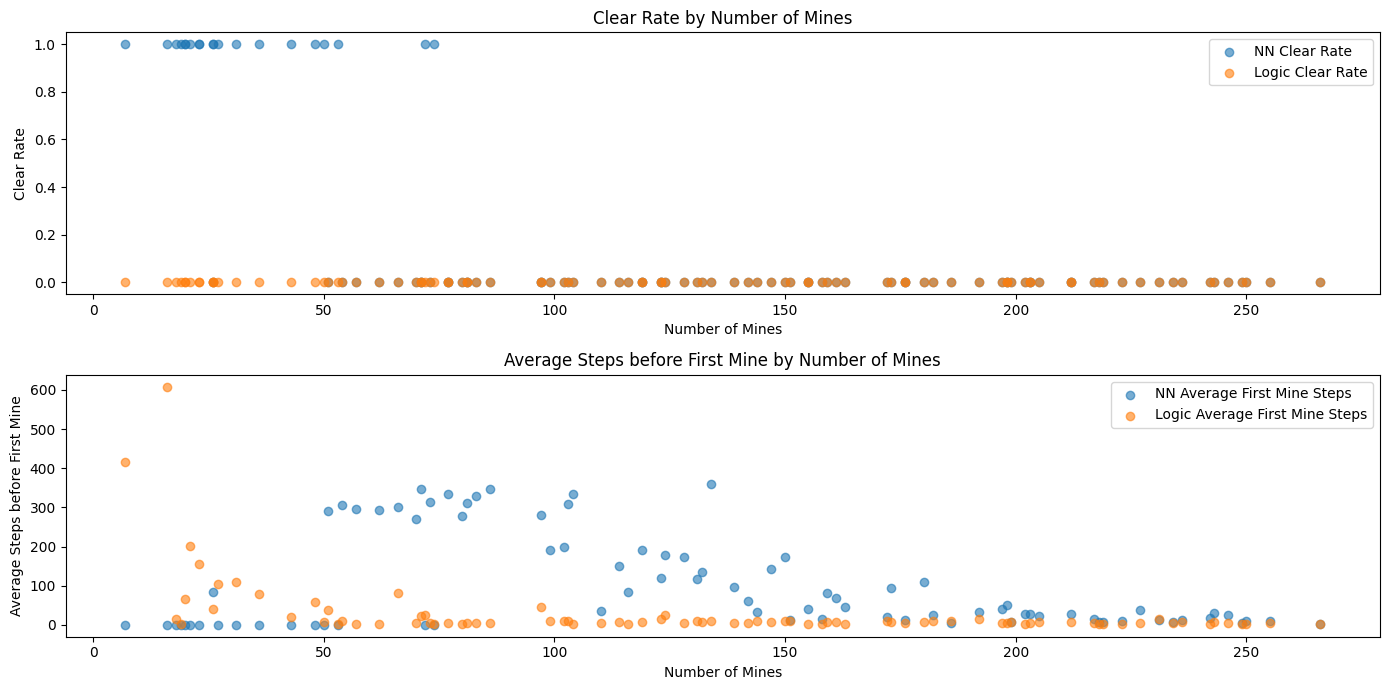

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
collect_results(100, model, 30, 30, False)

### Conclusions from Task 2

From the graph above, we can conclude that the neural network outperformed the logic bot when the number of mines was anywhere from 0 to around 75. After that point, both bots did not win. The neural network also took more steps on average than the logic bot. Thus, the neural network significantly outperformed the logic bot.

# Task 3

For this task, I was interested if I could make a CNN model that utilized attention, and then compare that CNN model to my two previous models.

While training remained the same, I did experience frustrations with my data. I at first thought that the dataset should consist of randomly sized boards. Quickly, I ran into the difficulty of batching a dataset with different sized inputs. I tried to pad the inputs to make them all the maximum size (50x50), but that hurt the overall training process. The models used the padded areas while learning, resulting in subpar results. Eventually, I decided to make a dataset of 50x50 boards with 500 mines each. The hope was that since the CNN models did not rely on the width/height of the board, they would be able to generalize to any size of board, even if they only trained on one size. I did decide to make AttentionCNN (the CNN with attention) have a global pooling layer, to make the dimensionality the CNN worked with consistent, theoretically leading to better results.

Based off the MinesweeperCNN model, AttentionCNN adds attention. The model starts with three convolutional layers, same as MinesweeperCNN. Then, a convolutional layer with a kernel size of 1 is used to learn attention weights for each feature in the feature map (importantly, the depth of the feature map does not change in this layer). The attention weights are obtained by passing the output of this layer through a sigmoid activation function. These weights are then multiplied with the feature maps produced by conv3. This allows the network to focus on more important features.

In [185]:
class AttentionCNN(nn.Module):
  def __init__(self, in_channels=11):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.attention = nn.Conv2d(128, 128, kernel_size=1)
    self.final_conv = nn.Conv2d(128, 1, kernel_size=1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))

    attention_weights = torch.sigmoid(self.attention(x))
    x = x * attention_weights

    x = self.final_conv(x)
    return torch.sigmoid(x).squeeze(1)

Redefined functions for plotting

In [186]:
def play_full_game(model, game, size, bot_type='NN', calc_mines=False):
  if bot_type == 'NN':
    bot = None
  else:
    bot = MinesweeperBot(game)

  moves_made = 0
  first_mine_hit = False
  first_mine_step = None
  mine_count = 0

  while not game.is_solved() and not game.game_over:
    if bot_type == 'NN':
      input_list = game.get_training_grid(calc_mines)
      input_tensor = prepare_model_input(input_list)
      input_tensor = input_tensor.to(device)
      probabilities = model(input_tensor)
      probabilities = torch.squeeze(probabilities)
      move = select_optimal_move(probabilities, game)
    else:
      move = bot.play_one_move()

    if move is None:
      break

    x, y = move
    result = game.uncover(x, y)
    moves_made += 1

    if result == 'mine':
      mine_count += 1
      if not first_mine_hit:
        first_mine_hit = True
        first_mine_step = moves_made
      if bot_type == 'logic':
        break

  game_over_status = game.is_solved()
  return game_over_status, moves_made, first_mine_step if first_mine_step else size * size, mine_count

def collect_and_plot_results(num_games_per_size, model):
  sizes = range(5, 51)
  results = {
    'size': [],
    'nn_clear_rate': [],
    'logic_clear_rate': [],
    'nn_first_mine_steps': [],
    'logic_first_mine_steps': [],
    'nn_mines_triggered': [],
    'logic_mines_triggered': []
  }

  for size in sizes:
    nn_clears, logic_clears = [], []
    nn_first_mines, logic_first_mines = [], []
    nn_mines_triggered, logic_mines_triggered = [], []

    for _ in range(num_games_per_size):
      mines = int(size * size * 0.2)
      game_nn = Minesweeper(size, size, mines)
      game_logic = Minesweeper(size, size, mines)

      res_nn = play_full_game(model, game_nn, size, 'NN')
      res_logic = play_full_game(model, game_logic, size, 'logic')

      nn_clears.append(res_nn[0])
      nn_first_mines.append(res_nn[2] if res_nn[2] else size*size)
      nn_mines_triggered.append(res_nn[3])

      logic_clears.append(res_logic[0])
      logic_first_mines.append(res_logic[2] if res_logic[2] else size*size)
      logic_mines_triggered.append(res_logic[3])

    results['size'].append(size)
    results['nn_clear_rate'].append(sum(nn_clears) / len(nn_clears))
    results['logic_clear_rate'].append(sum(logic_clears) / len(logic_clears))
    results['nn_first_mine_steps'].append(np.mean(nn_first_mines))
    results['logic_first_mine_steps'].append(np.mean(logic_first_mines))
    results['nn_mines_triggered'].append(np.mean(nn_mines_triggered))
    results['logic_mines_triggered'].append(np.mean(logic_mines_triggered))

  plt.figure(figsize=(14, 8))
  plt.subplot(311)
  plt.plot(results['size'], results['nn_clear_rate'], label='NN Clear Rate')
  plt.plot(results['size'], results['logic_clear_rate'], label='Logic Clear Rate')
  plt.title('Clear Rate Comparison')
  plt.xlabel('Board Size (K)')
  plt.ylabel('Clear Rate')
  plt.legend()

  plt.subplot(312)
  plt.plot(results['size'], results['nn_first_mine_steps'], label='NN First Mine Steps')
  plt.plot(results['size'], results['logic_first_mine_steps'], label='Logic First Mine Steps')
  plt.title('First Mine Steps Comparison')
  plt.xlabel('Board Size (K)')
  plt.ylabel('Average Steps')
  plt.legend()

  plt.subplot(313)
  plt.plot(results['size'], results['nn_mines_triggered'], label='NN Mines Triggered')
  plt.plot(results['size'], results['logic_mines_triggered'], label='Logic Mines Triggered')
  plt.title('Mines Triggered Comparison')
  plt.xlabel('Board Size (K)')
  plt.ylabel('Average Mines Triggered')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [171]:
width, height, num_mines = 50, 50, 50 * 12 * 0.2
inputs, outputs = generate_dataset(1000, width, height, num_mines)
test_inputs, test_outputs = generate_dataset(200, width, height, num_mines)

dataset = TensorDataset(inputs, outputs)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)
dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(dataset, batch_size=10, shuffle=False)

### With AttentionCNN (attention mechanism)

In [187]:
model = AttentionCNN()

train_model(model, train_loader, test_loader, 100, grace_period=5, permute=True)

Epoch 1: Train Loss: 0.21721683859825133, Test Loss: 0.18617052510380744
Model improved; saving new best model.
Epoch 2: Train Loss: 0.1806015883386135, Test Loss: 0.17679906412959098
Model improved; saving new best model.
Epoch 3: Train Loss: 0.17599203929305077, Test Loss: 0.17532501742243767
Model improved; saving new best model.
Epoch 4: Train Loss: 0.1751499754190445, Test Loss: 0.17496007159352303
Model improved; saving new best model.
Epoch 5: Train Loss: 0.174803679138422, Test Loss: 0.17469674348831177
Model improved; saving new best model.
Epoch 6: Train Loss: 0.17458363384008407, Test Loss: 0.17451456785202027
Model improved; saving new best model.
Epoch 7: Train Loss: 0.17443690910935403, Test Loss: 0.17453464344143868
Epoch 8: Train Loss: 0.17428955778479577, Test Loss: 0.17434579730033875
Model improved; saving new best model.
Epoch 9: Train Loss: 0.1742202615737915, Test Loss: 0.174310352653265
Model improved; saving new best model.
Epoch 10: Train Loss: 0.17418156683444

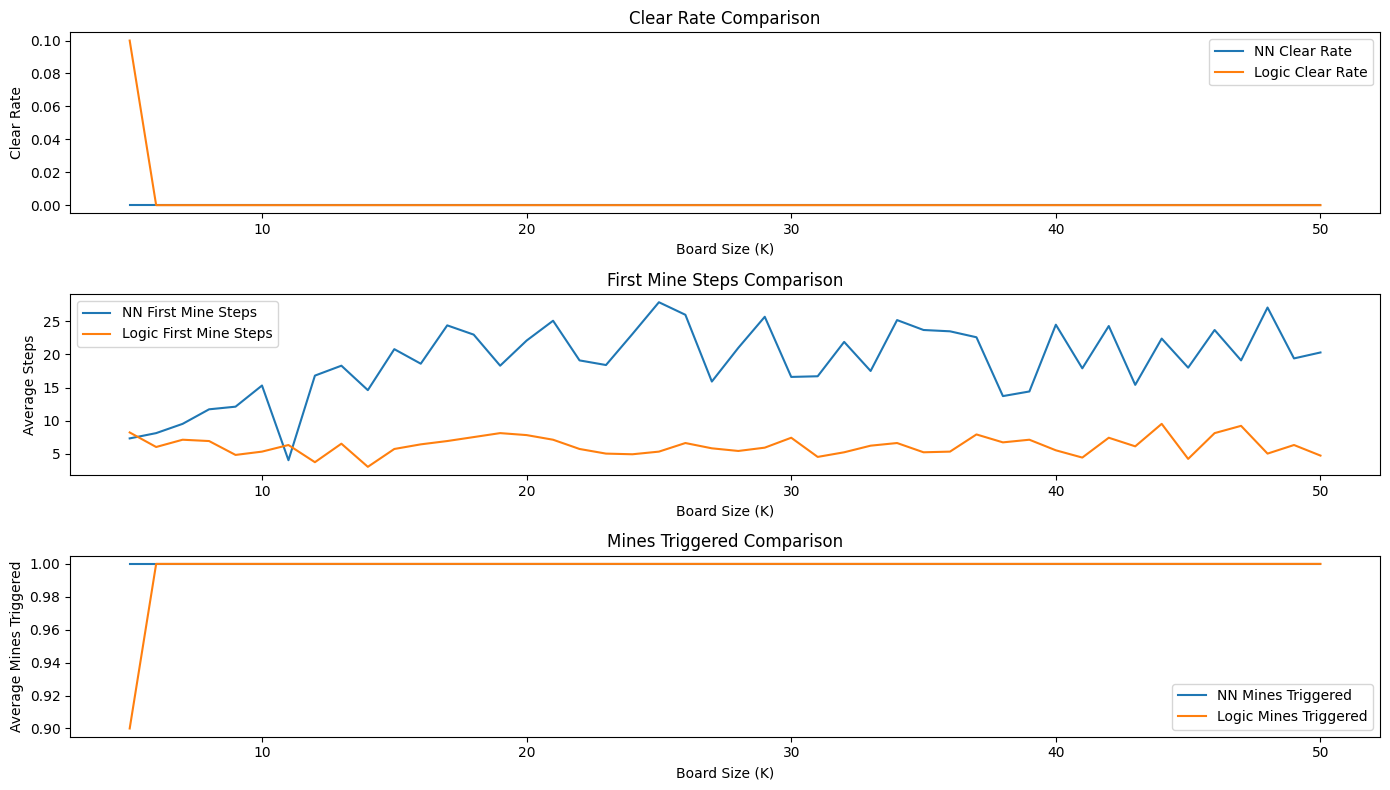

In [188]:
model.load_state_dict(torch.load('best_model.pth'))
collect_and_plot_results(10, model)

### With MinesweeperCNN (baseline)

In [179]:
model = MinesweeperCNN()

train_model(model, train_loader, test_loader, 100, grace_period=5, permute=True)

Epoch 1: Train Loss: 0.21822398155927658, Test Loss: 0.18473840430378913
Model improved; saving new best model.
Epoch 2: Train Loss: 0.18006972581148148, Test Loss: 0.17781980708241463
Model improved; saving new best model.
Epoch 3: Train Loss: 0.17682702273130416, Test Loss: 0.17613963782787323
Model improved; saving new best model.
Epoch 4: Train Loss: 0.17584528714418413, Test Loss: 0.17555760145187377
Model improved; saving new best model.
Epoch 5: Train Loss: 0.17530287593603133, Test Loss: 0.17513774931430817
Model improved; saving new best model.
Epoch 6: Train Loss: 0.17511971652507782, Test Loss: 0.17489513531327247
Model improved; saving new best model.
Epoch 7: Train Loss: 0.1748298789560795, Test Loss: 0.17482755109667777
Model improved; saving new best model.
Epoch 8: Train Loss: 0.17468221187591554, Test Loss: 0.17470978423953057
Model improved; saving new best model.
Epoch 9: Train Loss: 0.17453523442149163, Test Loss: 0.17458464875817298
Model improved; saving new best 

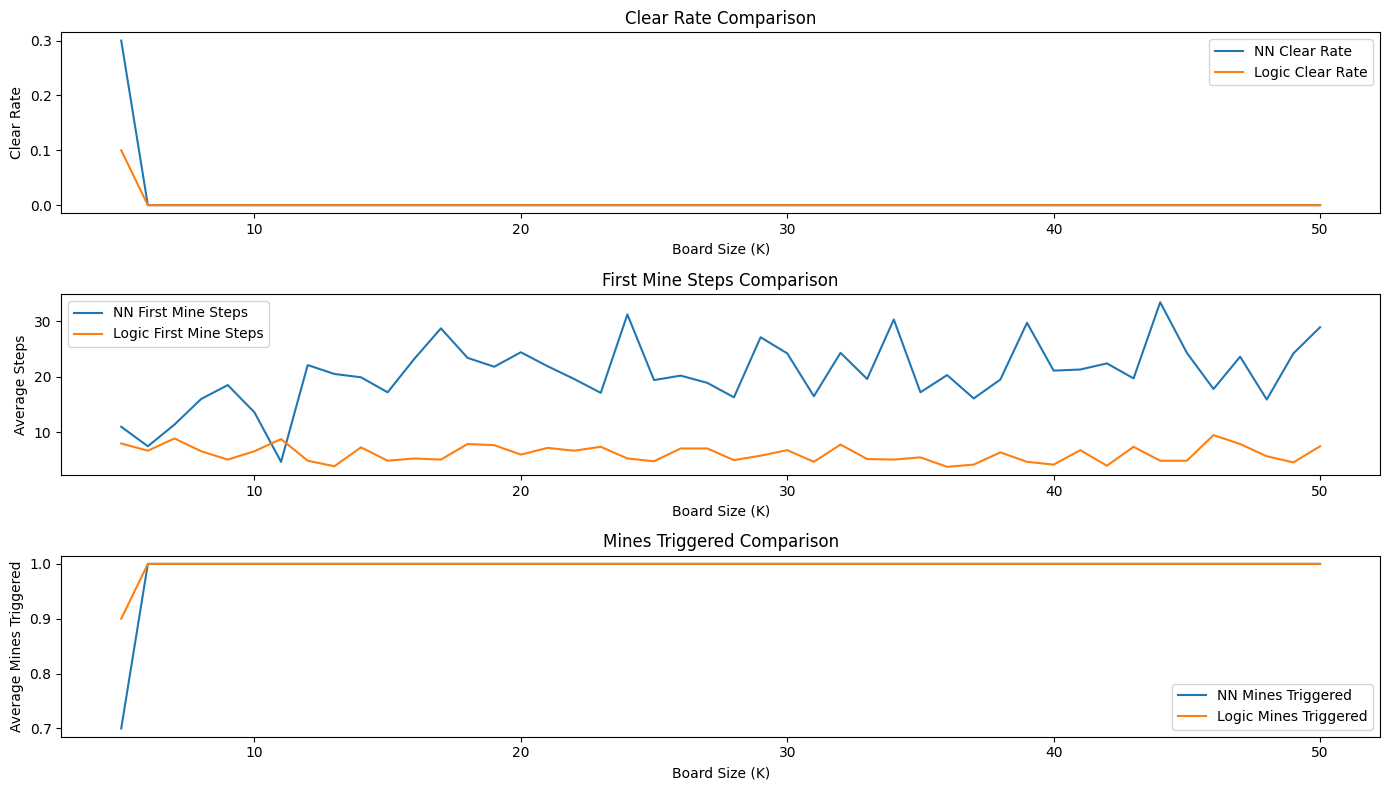

In [182]:
model.load_state_dict(torch.load('best_model.pth'))
collect_and_plot_results(10, model)

### With EnhancedMinesweeperCNN (dropout and regularization)

In [183]:
model = EnhancedMinesweeperCNN()

train_model(model, train_loader, test_loader, 100, grace_period=5, permute=True)

Epoch 1: Train Loss: 0.20555888697504998, Test Loss: 0.17969710975885392
Model improved; saving new best model.
Epoch 2: Train Loss: 0.18266552537679673, Test Loss: 0.17647426724433898
Model improved; saving new best model.
Epoch 3: Train Loss: 0.17982634887099266, Test Loss: 0.17625970020890236
Model improved; saving new best model.
Epoch 4: Train Loss: 0.17874170899391173, Test Loss: 0.17579223439097405
Model improved; saving new best model.
Epoch 5: Train Loss: 0.1779124531149864, Test Loss: 0.17529962360858917
Model improved; saving new best model.
Epoch 6: Train Loss: 0.17708414033055306, Test Loss: 0.174911530315876
Model improved; saving new best model.
Epoch 7: Train Loss: 0.1770328763127327, Test Loss: 0.17486325800418853
Model improved; saving new best model.
Epoch 8: Train Loss: 0.17665210649371146, Test Loss: 0.21772212013602257
Epoch 9: Train Loss: 0.17653605863451957, Test Loss: 0.187383995950222
Epoch 10: Train Loss: 0.17613933488726616, Test Loss: 0.17493123039603234
Ep

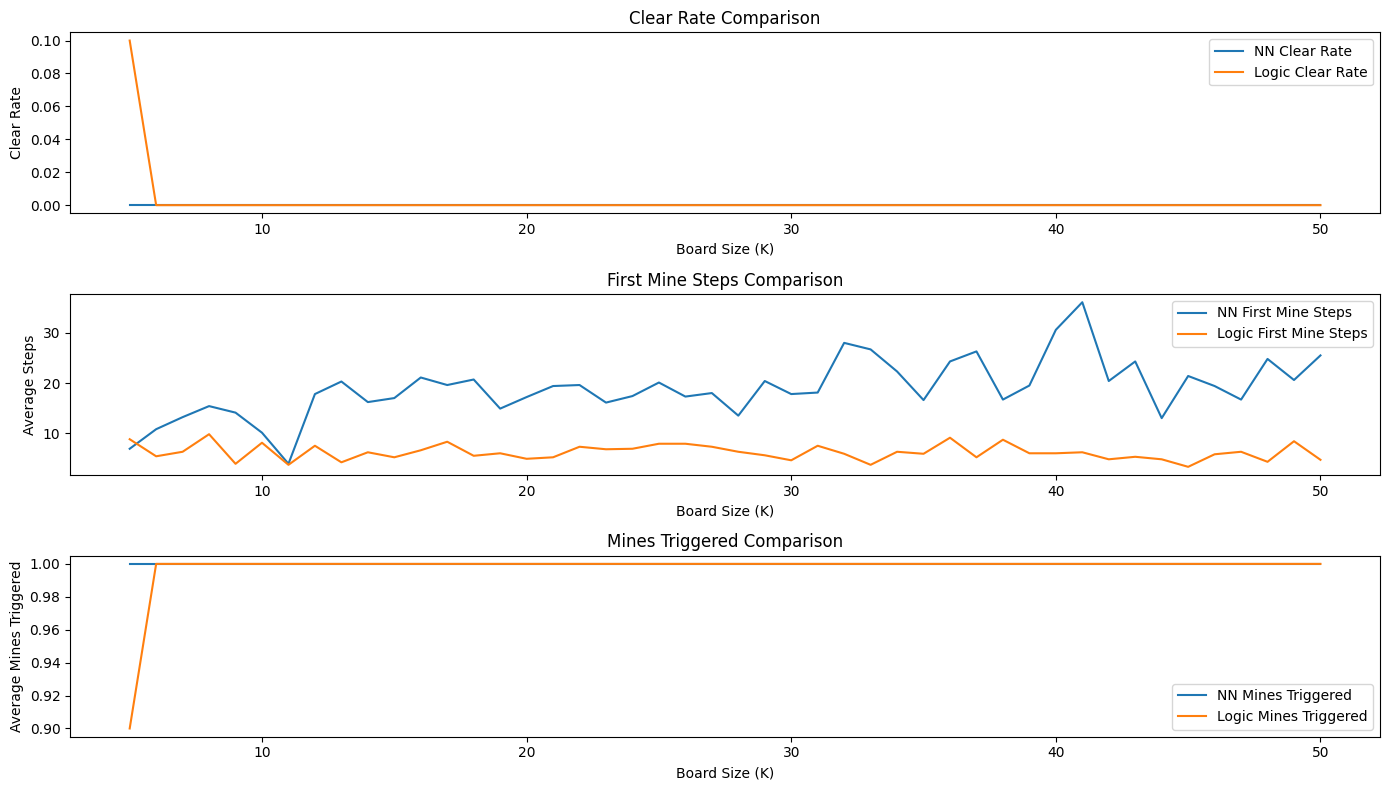

In [184]:
model.load_state_dict(torch.load('best_model.pth'))
collect_and_plot_results(10, model)

### Conclusions from Task 3

Surprisingly, the baseline MinesweeperCNN managed to beat the logic bot in both the average steps and win rate (it won more games at the start relative to the logic bot).

The EnhancedMinesweeperCNN, which I was expecting to outperform the baseline CNN, did not win any games. However, it did have consistently more average steps taken than the logic bot.

The AttentionCNN was comparable to the EnhancedMinesweeperCNN. It did not win any games, but did consistently have more average steps taken before triggering a mine relative to the logic bot.

Overall, the MinesweeperCNN was the best performing model for this task.

These results were, frankly, surprising to me. I was expecting the attention mechanism to result in the AttentionCNN to easily beat the MinesweeperCNN when board sizes were varying.

# RNN v. CNN

One question worth experimenting with is if it is better to view the game sequentially or by current state. The CNN models use the state of the game. An RNN would use sequential data to determine the best move. Let's see what happens when we use an RNN to play Minesweeper.

MinesweeperRNN is structured to work with sequential data. In this case a sequence can represent a game state over time. It interprets the entire sequence of game states, focuses on the final representation after processing the sequence, and then predicts a set of probabilities for each cell in the game.

In [8]:
class MinesweeperRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_cells):
    super(MinesweeperRNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_cells)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    out, _ = self.rnn(x, h0)
    out = self.fc(out[:, -1, :])
    return torch.sigmoid(out)


Redefined functions to work with RNN

In [ ]:
def prepare_model_input(game_data, height=9, width=9):
  input_tensor = torch.tensor(game_data, dtype=torch.float32)
  input_tensor = input_tensor.view(1, height * width, 11)

  return input_tensor

def select_optimal_move(probabilities, game):
  min_prob = 1
  best_move = None
  probabilities = probabilities.view(game.height, game.width)
  for y in range(game.height):
    for x in range(game.width):
      if game.covered[y][x] and probabilities[y, x].item() < min_prob:
        min_prob = probabilities[y, x].item()
        best_move = (x, y)
  return best_move

In [9]:
width, height, num_mines = 9, 9, 10
inputs, outputs = generate_dataset(10000, width, height, num_mines)
test_inputs, test_outputs = generate_dataset(2000, width, height, num_mines)
dataset = TensorDataset(inputs, outputs)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [10]:
model = MinesweeperRNN(input_size=11, hidden_size=64, num_layers=2, num_cells=81)
train_model(model, train_loader, test_loader, 100, rnn=True)

Epoch 1: Train Loss: 0.3881511314037128, Test Loss: 0.37446893538747517
Model improved; saving new best model.
Epoch 2: Train Loss: 0.3745421334958305, Test Loss: 0.3746961795148395
Epoch 3: Train Loss: 0.37458241433381273, Test Loss: 0.3745581484030163
Epoch 4: Train Loss: 0.3746200493349435, Test Loss: 0.37441860872601707
Model improved; saving new best model.
Epoch 5: Train Loss: 0.3745945872018893, Test Loss: 0.3744342710290636
Epoch 6: Train Loss: 0.3745187977061104, Test Loss: 0.37473258565342615
Epoch 7: Train Loss: 0.37454266965198824, Test Loss: 0.37448866641710676
Epoch 8: Train Loss: 0.37458810895776595, Test Loss: 0.37436249521043563
Model improved; saving new best model.
Epoch 9: Train Loss: 0.374605161599077, Test Loss: 0.3745813880647932
Epoch 10: Train Loss: 0.3745443960919548, Test Loss: 0.37445647044787334
Epoch 11: Train Loss: 0.3745495020962371, Test Loss: 0.37459479248712935
Epoch 12: Train Loss: 0.3744984352931428, Test Loss: 0.3744378037868984
Epoch 13: Train Los

In [16]:
model.load_state_dict(torch.load('best_model.pth'))
collect_results(100, model, 9, 9, 10)

NN Bot - Win rate: 0.0, Avg moves: 6.55
Logic Bot - Win rate: 0.0, Avg moves: 11.04


The results show that on 'easy' mode, the RNN is outperformed by the logic bot, and significantly worse than MinesweeperCNN. I do admit that this way to tackle the problem is not fully fleshed out. I think my data could be better, and I also think my model may be too simple. What this does show is that it is possible to view the game sequentially.

Now, I don't think it is better to view the game sequentially. A current game state does not really depend on a previous game state for the context of this problem. For instance, if I sat down in front of a half-finished game of Minesweeper, I would not need previous context to know what to do. I could simply scan the board and figure out the next best move. The same here. The way the game is played, it makes less sense to view the game sequentially, thus making a CNN the better choice.

# Overall Conclusion

The models I created outperformed the logic bot (other than the RNN).

I determined that attention can be applied here in a useful way (see Task 3), and also determined that sequential data is possible, but probably not ideal.

While I am happy with my results, in the future, I want to revisit this problem and experiment more with attention. I believe if used properly and with a well-defined model, it would outperform the current models I am using.